In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
os.getcwd()

'C:\\Users\\p.schambach\\Desktop\\DSR\\drone_steering\\models\\playground'

In [5]:
os.chdir('../..')

In [6]:
from app_local.module import DataEnsembler, GestureTransformer

In [7]:
is_frame_based = True

In [8]:
de = DataEnsembler(ms_per_frame=120)
de.investigate_available_datafiles(data_dir='data/gesture/', is_frame_based = is_frame_based)

In [9]:
de.load_data()

# Rescaling and Interpolation
use_rescaling_to_true_length = False
use_interpolation = False
is_verbose = True

if use_rescaling_to_true_length:
        de.rescale_data_frames( time_of_first_frame = 'avg', verbose = is_verbose)

if use_interpolation:
    if is_frame_based:
        de.interpolate_and_convert_framebased_labels(new_frmlen = 50, verbose = is_verbose)
    else:
        de.interpolate_data_frames( frmlen = 50, verbose = is_verbose)
  

In [10]:
if is_frame_based:
    de.assemble_data()
else:
    de.assemble_data(tolerance_range = 600, max_error = 550)
    
de.display_information()

i: 0 	shape X: (604, 17, 16) 	shape y: (604,) 	count: 55
i: 1 	shape X: (520, 17, 16) 	shape y: (520,) 	count: 37
i: 2 	shape X: (499, 17, 16) 	shape y: (499,) 	count: 59
i: 3 	shape X: (651, 17, 16) 	shape y: (651,) 	count: 135
i: 4 	shape X: (509, 17, 16) 	shape y: (509,) 	count: 95
i: 5 	shape X: (467, 17, 16) 	shape y: (467,) 	count: 90
i: 6 	shape X: (602, 17, 16) 	shape y: (602,) 	count: 88
i: 7 	shape X: (441, 17, 16) 	shape y: (441,) 	count: 83
i: 8 	shape X: (491, 17, 16) 	shape y: (491,) 	count: 70
i: 9 	shape X: (477, 17, 16) 	shape y: (477,) 	count: 74
i: 10 	shape X: (493, 17, 16) 	shape y: (493,) 	count: 85
i: 11 	shape X: (437, 17, 16) 	shape y: (437,) 	count: 63
i: 12 	shape X: (467, 17, 16) 	shape y: (467,) 	count: 86
i: 13 	shape X: (552, 17, 16) 	shape y: (552,) 	count: 71
i: 14 	shape X: (551, 17, 16) 	shape y: (551,) 	count: 58
i: 15 	shape X: (550, 17, 16) 	shape y: (550,) 	count: 55
i: 16 	shape X: (542, 17, 16) 	shape y: (542,) 	count: 49
i: 17 	shape X: (536, 1

In [11]:
feature_names = list(de.feature_names)
feat_dict = {feature:feature_names.index(feature) for feature in feature_names}
feat_dict

{'leftElbow_x': 0,
 'leftElbow_y': 1,
 'leftHip_x': 2,
 'leftHip_y': 3,
 'leftShoulder_x': 4,
 'leftShoulder_y': 5,
 'leftWrist_x': 6,
 'leftWrist_y': 7,
 'rightElbow_x': 8,
 'rightElbow_y': 9,
 'rightHip_x': 10,
 'rightHip_y': 11,
 'rightShoulder_x': 12,
 'rightShoulder_y': 13,
 'rightWrist_x': 14,
 'rightWrist_y': 15}

In [12]:
def plot_charts(de, file_id, tail=5, head=5, plots_per_row=30, body_part='leftWrist', is_frame_based = True):

    global movements
    
    kx = body_part + '_x'
    ky = body_part + '_y'

    lgen = de.LabelGenerators[file_id]
    y = lgen.y
    n = len(lgen.y)

    gt = GestureTransformer(byrow=True, feature_names=feature_names)
    X = gt.transform(lgen.X)
    s = lgen.X.shape[1]

    d = lgen.labeled_data
    dims = d[feature_names].shape
    D = d[feature_names].values.reshape(1,dims[0],dims[1])
    D = gt.transform(D).reshape(dims[0],dims[1])
    Dx = D[:,feat_dict[kx]]
    Dy = D[:,feat_dict[ky]]    
    
    for j in range(n // plots_per_row + 1):
        
        plt.figure(figsize=(2 * plots_per_row, 2))
        
        for i in range (plots_per_row):
            plt.subplot(1, plots_per_row, i + 1)
            index = j*plots_per_row + i

            # specify axes range
            axes = plt.gca()
            axes.set_xlim([-2,2])
            axes.set_ylim([-2,2])
            axes.get_yaxis().set_visible(False)
            axes.get_xaxis().set_visible(False)

            if index < n:
                title_suffix = ''
                if (int(y[index])>0):
                    axes.set_facecolor((0.95, 0.95, 0.95))
                    title_suffix = ' | ' + movements[int(y[index])]

                # movement
                l1, u1 = max(0,index - s), index
                plt.plot(Dx[l1:u1],Dy[l1:u1],color = "xkcd:baby blue")

                # past
                l2, u2 = max(0,index - s - tail), max(0,index-s)
                plt.plot(Dx[l2:u2+1],Dy[l2:u2+1],linestyle = "--",color = "green")

                # future
                l3, u3 = index, min(index + head,dims[0])
                plt.plot(Dx[l3:u3],Dy[l3:u3],linestyle = "--",color = "red")
                
                # current frame
                plt.plot(Dx[u1-1],Dy[u1-1],color = "xkcd:baby blue",marker = "o")
                
                if is_frame_based:
                    plt.title(str(index) + title_suffix)
                else:
                    plt.title(str(index) + "/" + str(round(lgen.sequence_end_time[index]/1000,2)) + " l=" + str(int(y[index])))
                

        plt.show()
        plt.close()    

Available body parts:
```
leftElbow
leftHip
leftShoulder
leftWrist
rightElbow
rightHip
rightShoulder
rightWrist
```

In [13]:
de.combined_data_files_df

,filename_features,filename_labels
0,features_flip_c_01_120.csv,labels_flip_c_01.csv
1,features_flip_c_02_120.csv,labels_flip_c_02.csv
2,features_flip_c_03_120.csv,labels_flip_c_03.csv
3,features_flip_l_01_120.csv,labels_flip_l_01.csv
4,features_flip_l_02_120.csv,labels_flip_l_02.csv
5,features_flip_l_03_120.csv,labels_flip_l_03.csv
6,features_flip_p_01_120.csv,labels_flip_p_01.csv
7,features_land_c_01_120.csv,labels_land_c_01.csv
8,features_land_c_02_120.csv,labels_land_c_02.csv
9,features_land_c_03_120.csv,labels_land_c_03.csv


**Legend:**<br>
<span style="color:blue">gesture</span><br>
<span style="color:red">frames *after* gesture</span><br>
<span style="color:green">frames *before* gesture</span>

In [14]:
movements = {0: 'not detected',
             1: 'takeoff',
             2: 'move',
             3: 'flip',
             4: 'left',
             5: 'right',
             6: 'land'}

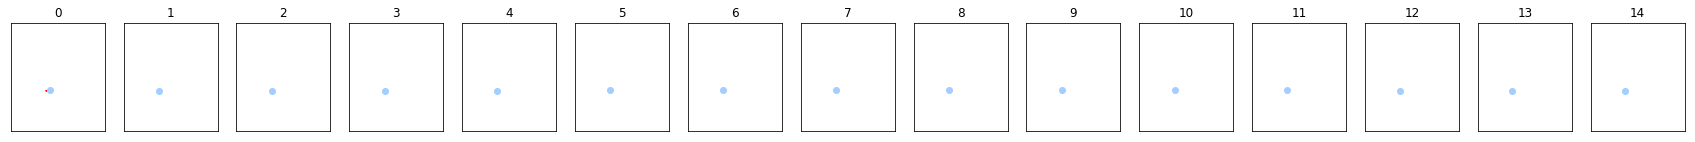

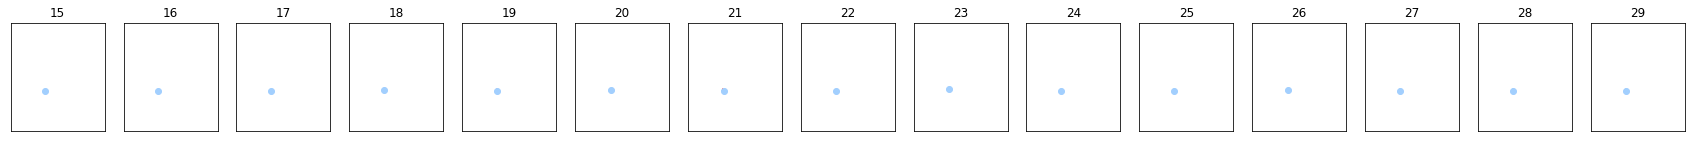

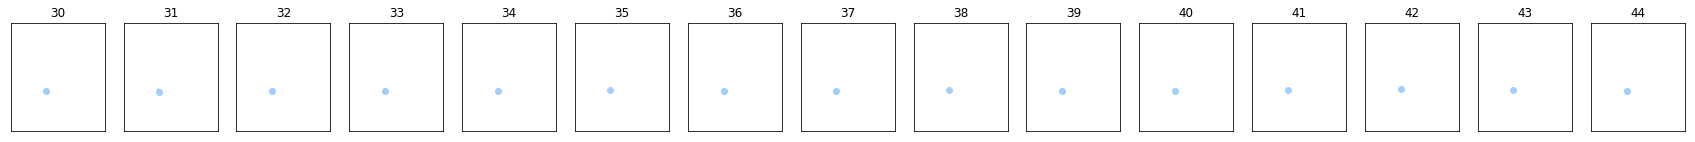

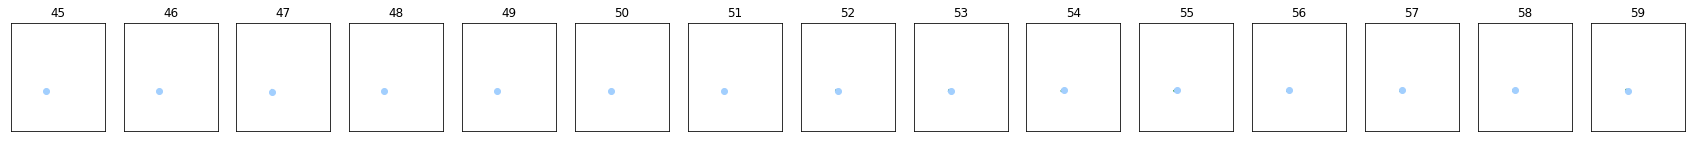

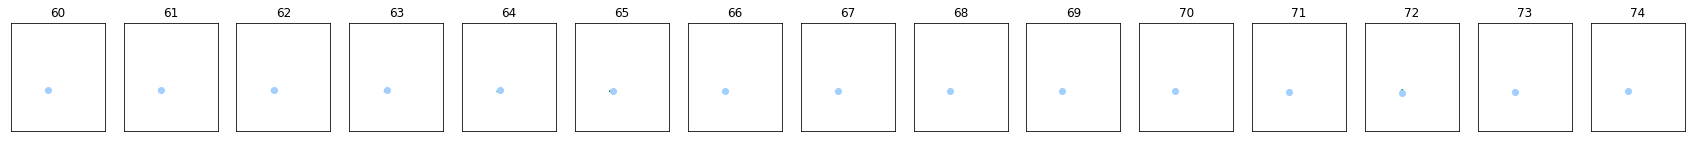

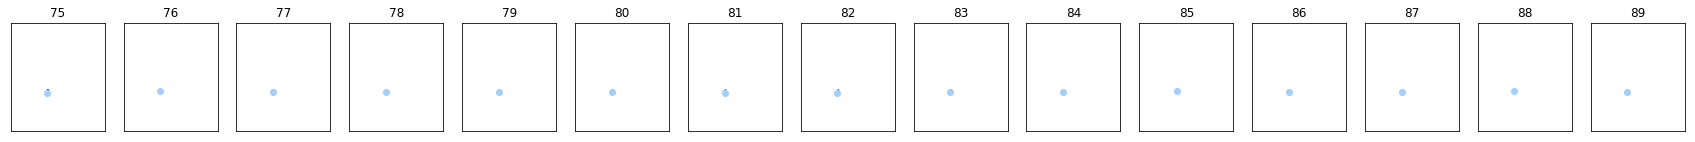

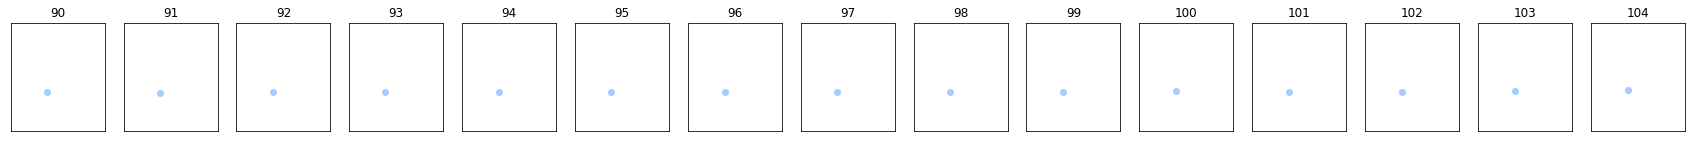

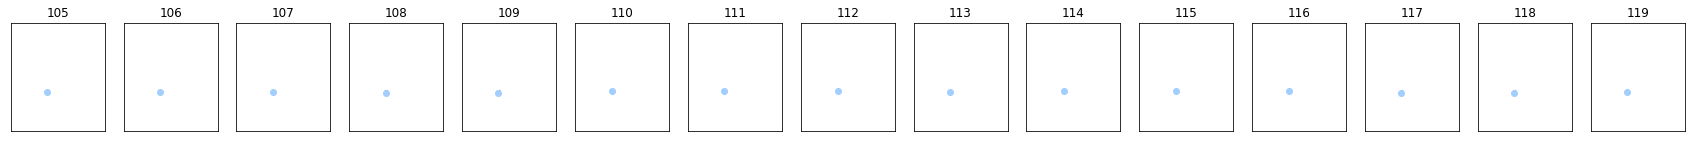

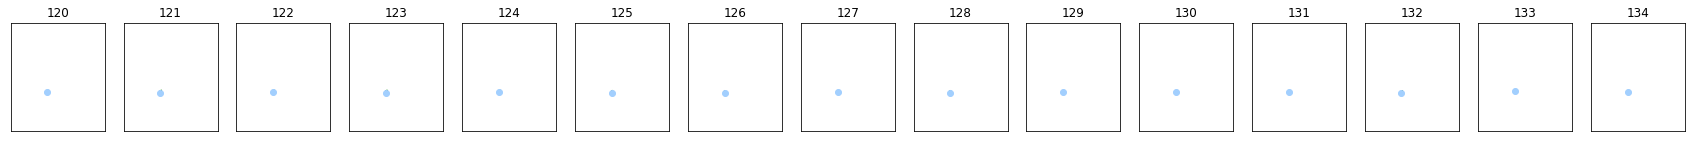

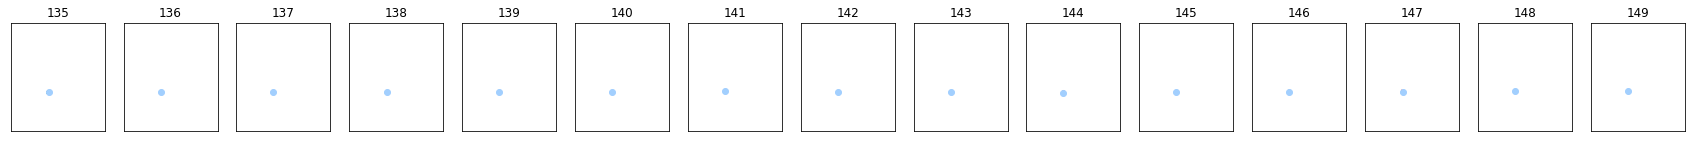

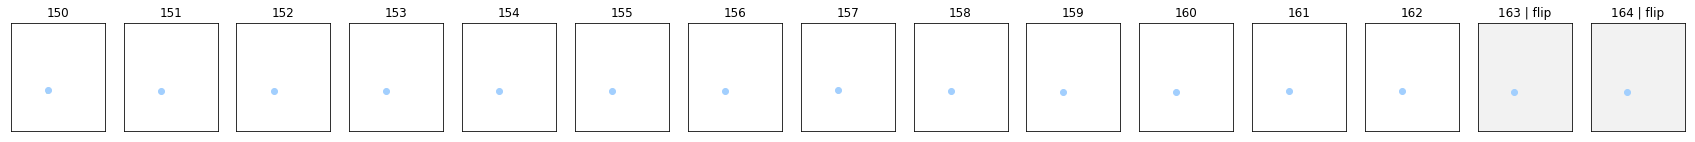

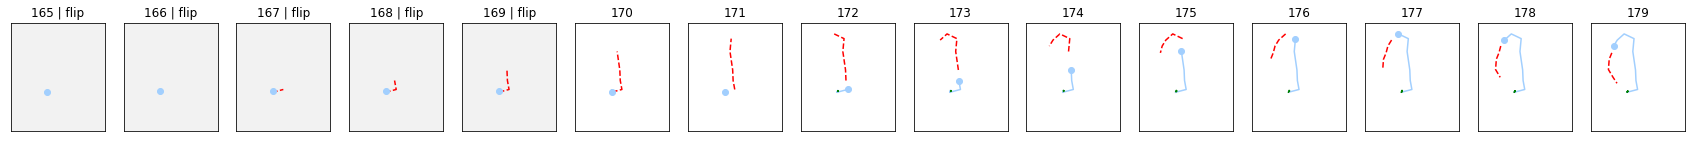

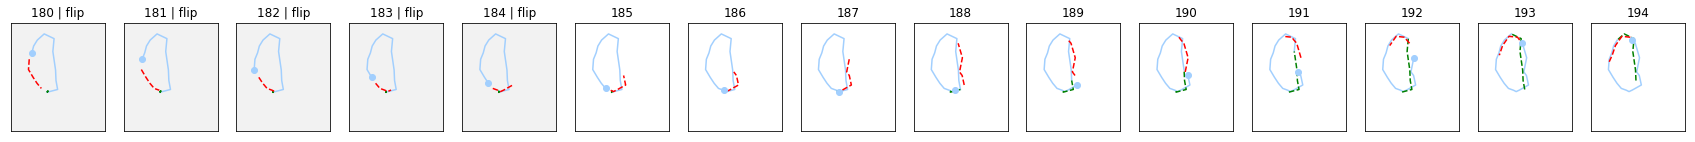

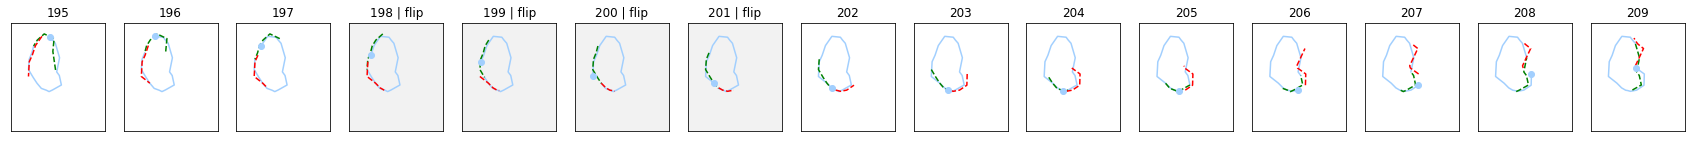

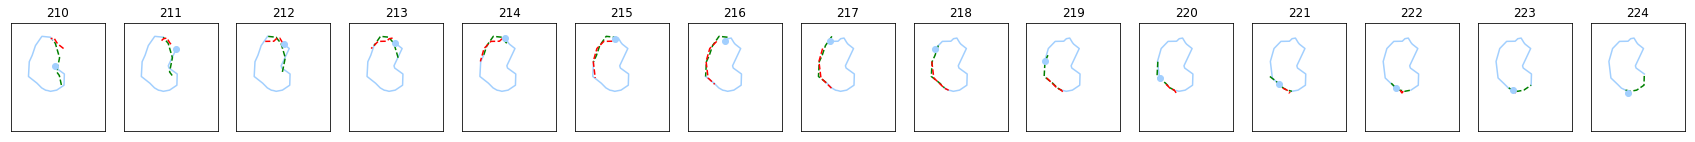

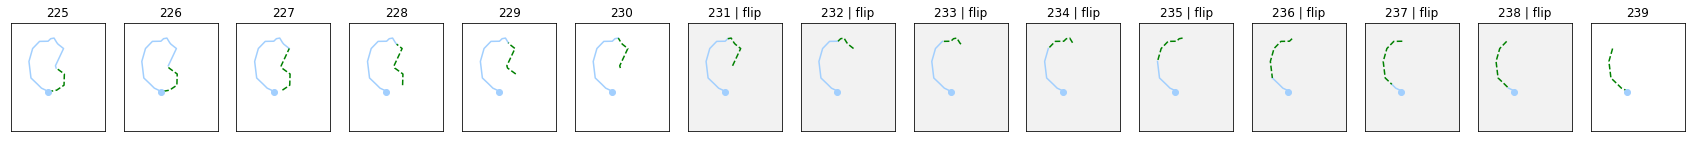

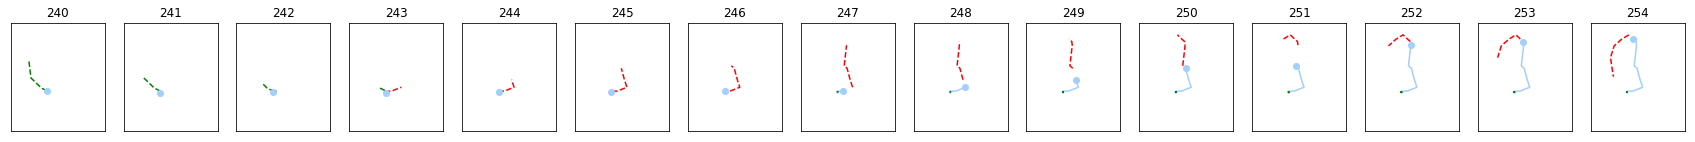

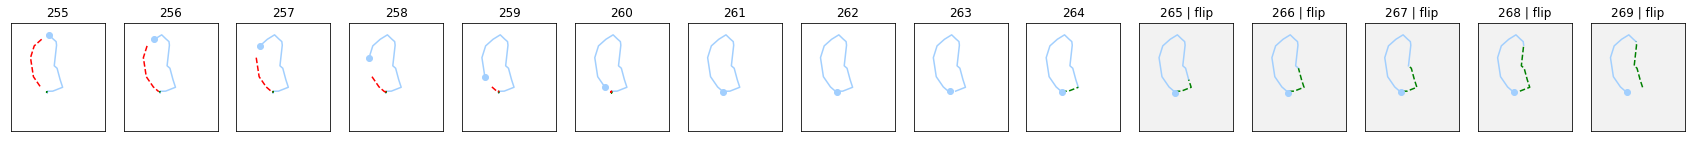

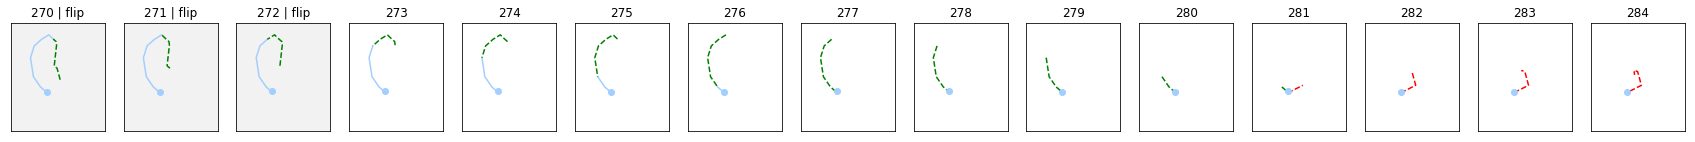

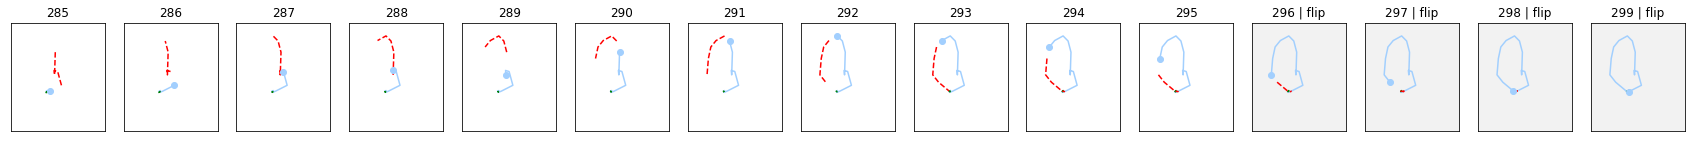

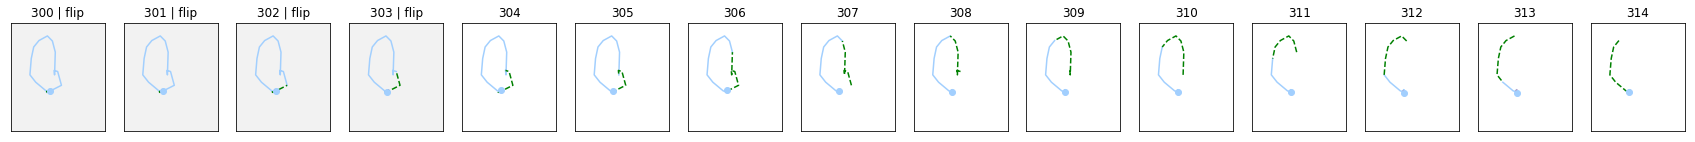

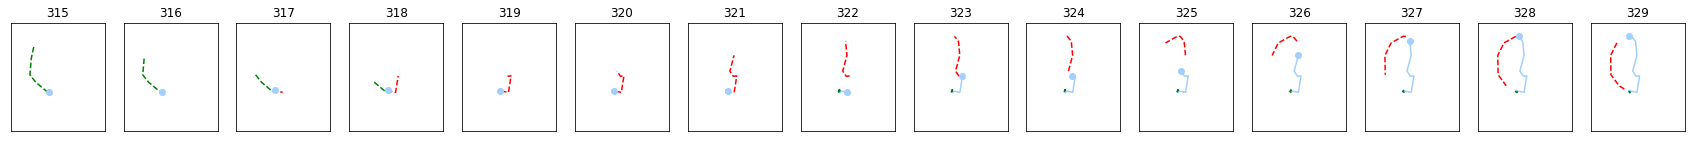

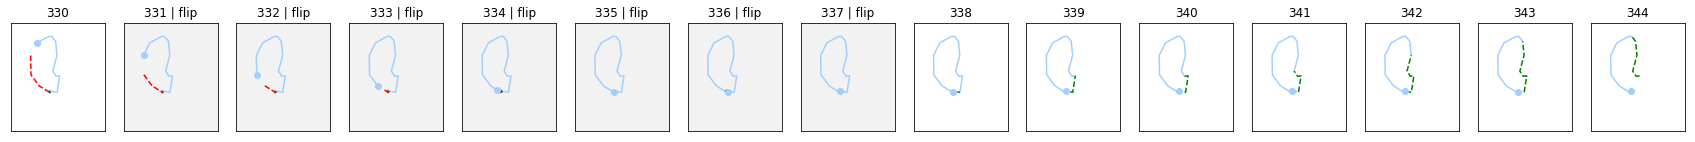

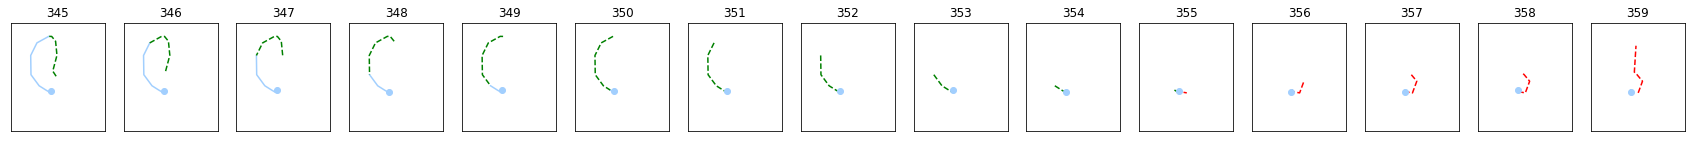

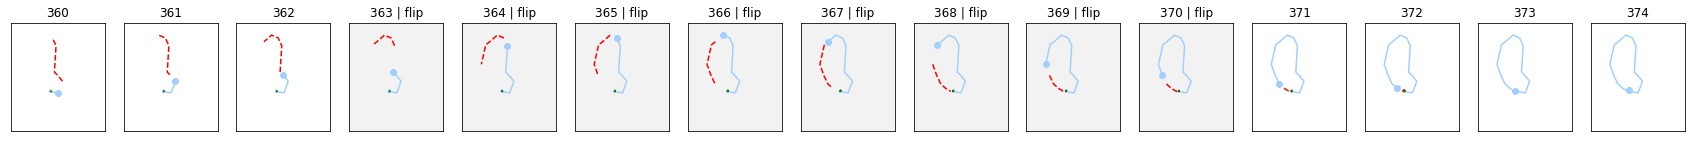

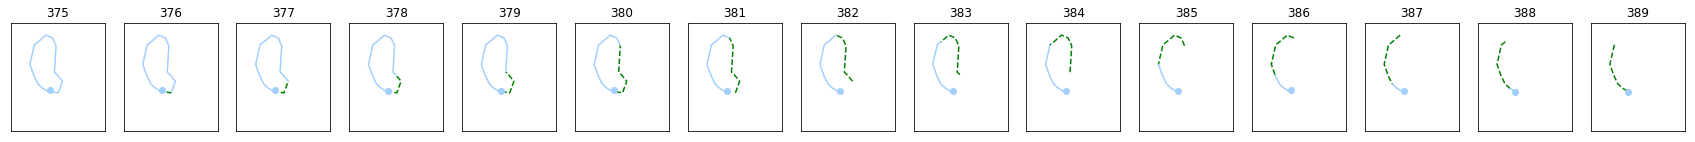

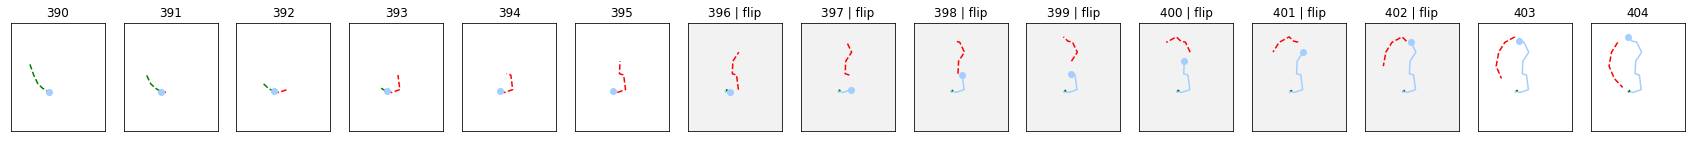

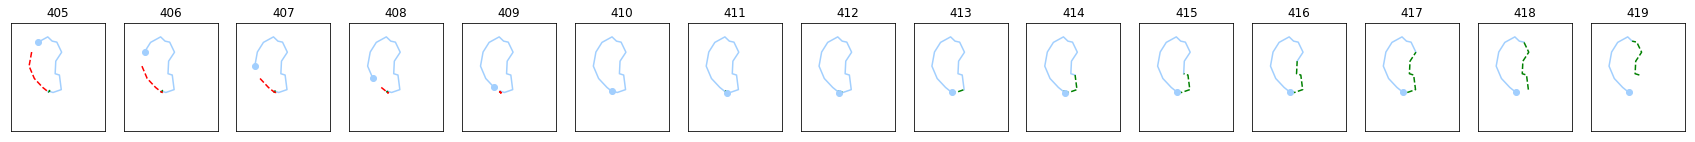

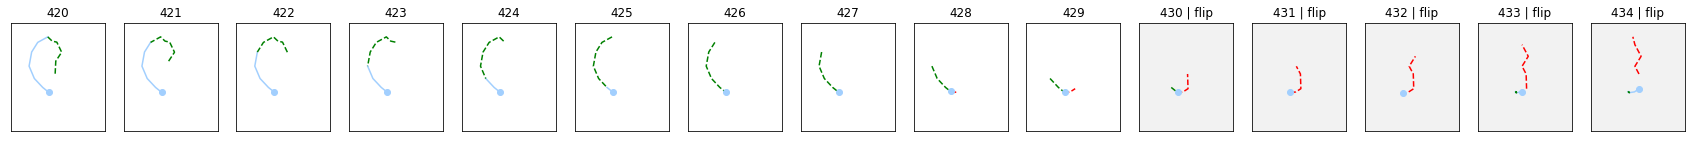

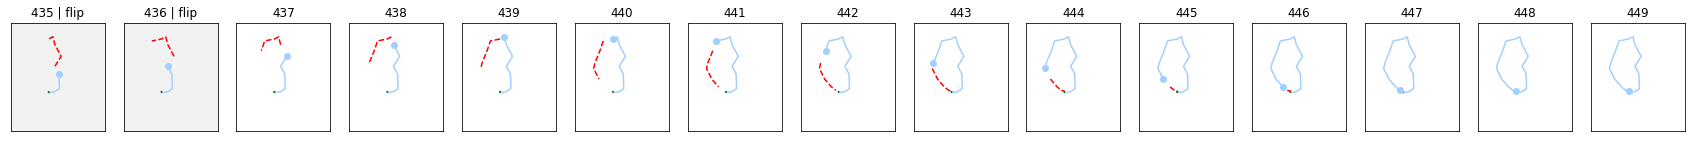

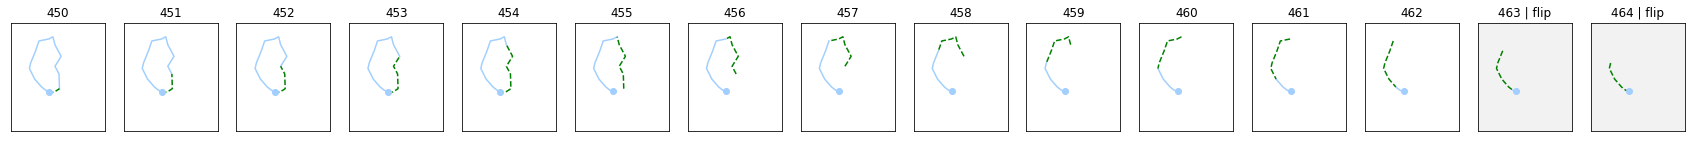

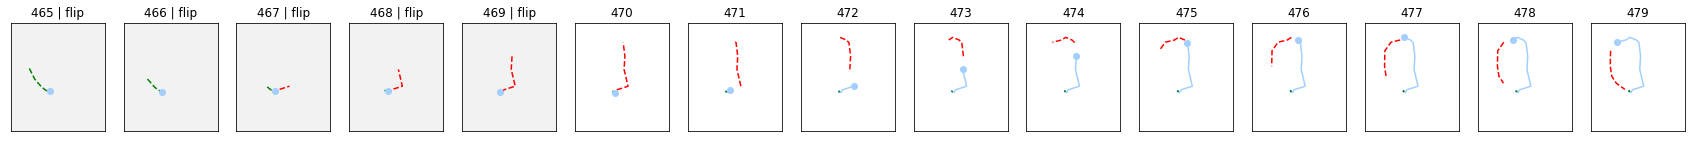

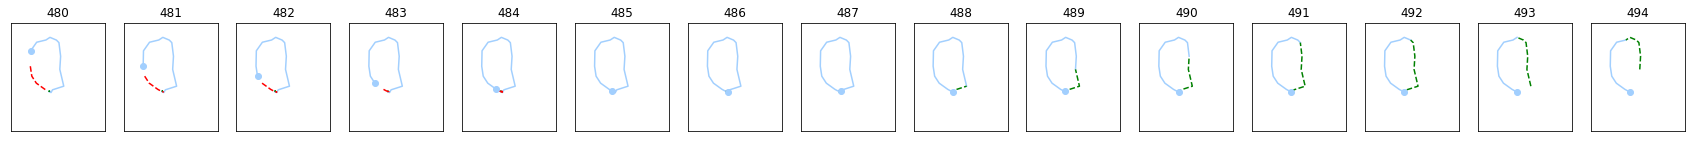

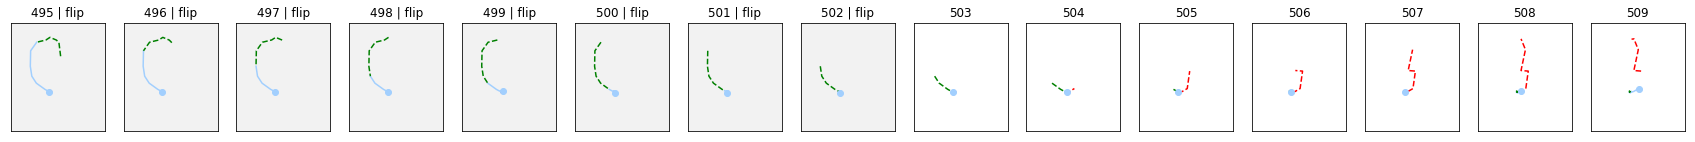

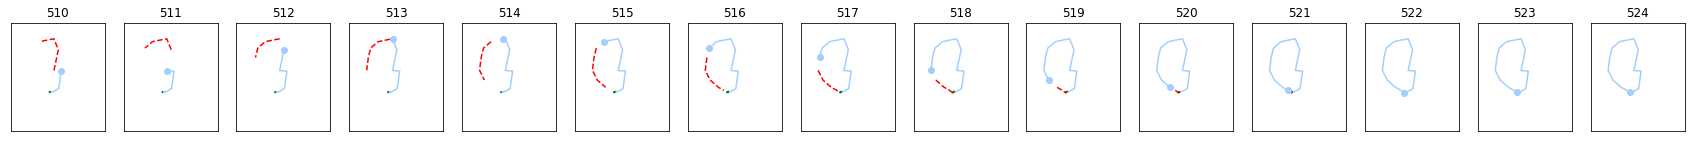

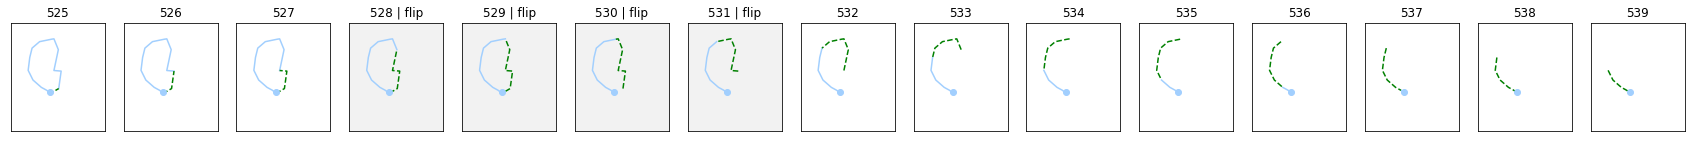

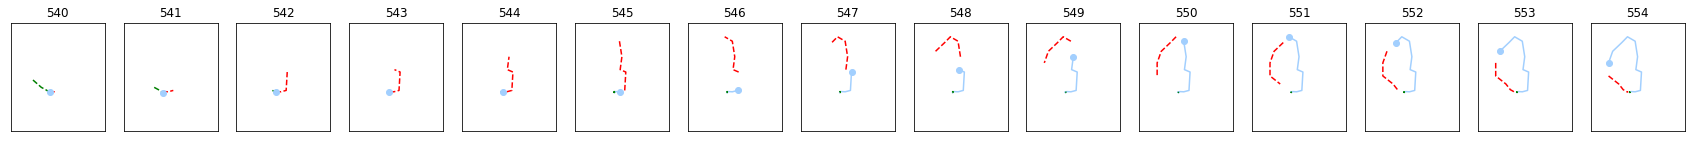

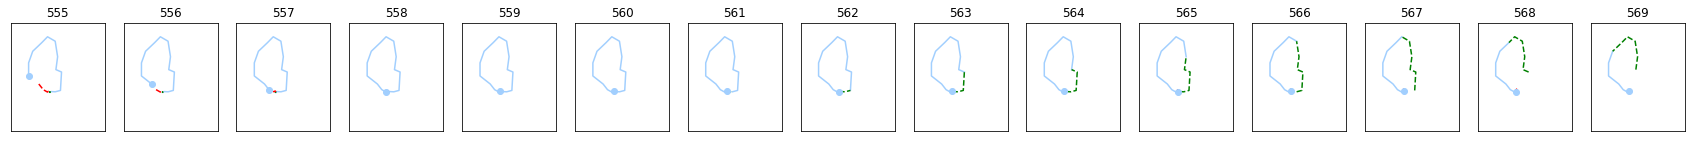

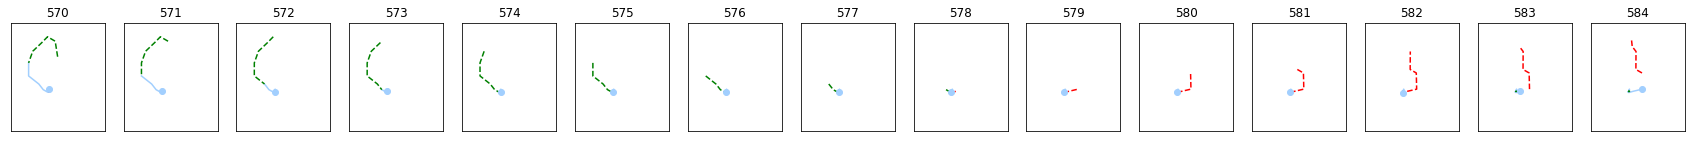

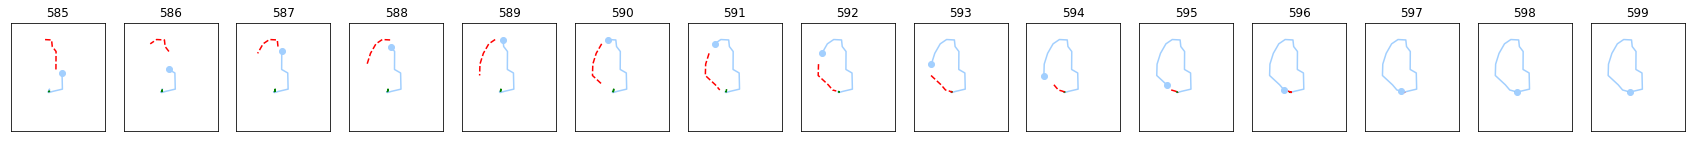

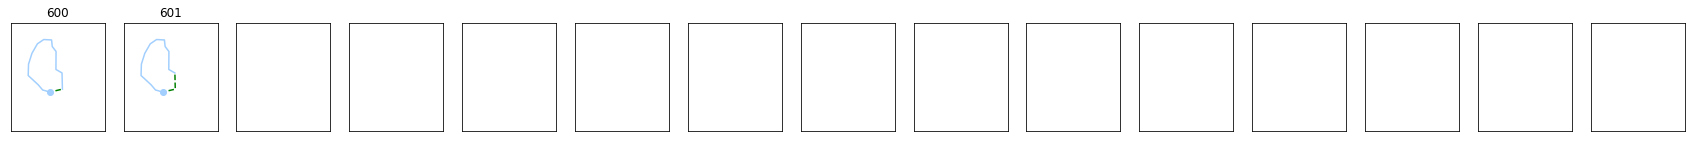

In [15]:
file_id = 6
plot_charts(de, file_id=file_id, tail=5, head=5, plots_per_row=15, body_part='leftWrist', is_frame_based = is_frame_based)

Display the movement endpoints (in milliseconds) of all non-zero labeled gestures:

In [16]:
de.LabelGenerators[file_id].label_df.join(de.LabelGenerators[file_id].label_info)

AttributeError: 'LabelGeneratorFramebased' object has no attribute 'label_df'

Display the indices of movement ends of all non-zero labeled gestures:

In [ ]:
lgen = de.LabelGenerators[file_id]
y = lgen.y

gt = GestureTransformer(byrow=True, feature_names=feature_names)
X = gt.transform(lgen.X)

gt = GestureTransformer(feature_names)
P = gt.transform(de.X)

key = 'leftWrist'
kx = key + '_x'
ky = key + '_y'

# get the label which is used in the current file
lab = y[y>0][0]

this_set = True
if not this_set: #use all the data
    movementData = P[np.isclose(de.y,lab),:,:]
else:
    movementData = X[np.isclose(y,lab),:,:]

print(movementData.shape)
movementData = movementData[:,:,[feat_dict[kx],feat_dict[ky]]]
avgMovement = movementData.mean(axis = 0)
avgMovement